# 简单理解 LT-DF SOS RMP2

> 创建时间：2019-10-17；最后修改：2021-06-12

这一节承接上一节对 DF-MP2 的讨论。我们知道 DF-MP2 的计算耗时尽管比传统 MP2 低但仍然是 $O(N^5)$；这一节作的 LT-DF SOS 近似则可以确实地将计算复杂度降低为 $O(N^4)$。

:::{note}

LT-DF SOS MP2 的写法并不是目前通用的写法；可能目前也没有通用的写法。

该名称的含义是 Laplace-Transformation Density-Fitting Scaled Opposite-Spin Second Order Moller-Plesset。

不要被这么长的名称吓到。除了 LT 之外，其它的过程或者非常容易实现 (SOS)，或者是我们已经理解的内容 (DF, MP2)。

:::

In [1]:
%matplotlib notebook

import numpy as np
import scipy
import quadpy
from functools import partial
import matplotlib.pyplot as plt

from pyscf import gto, scf, mp, df

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.set_printoptions(8, linewidth=150, suppress=True)

在这篇文档中，我们将会将测评体系更换为乙烯分子。这主要是为了与 Jung et al. [^Jung-Head-Gordon.JCP.2004.121] 文章中 Table I 的数据作比较。

:::{admonition} 冻核近似说明

这篇文章采用了 MP2 的冻核近似 (Frozen Core)；因此我们之后的 MP2 计算也需要相应地采用冻核近似。据我所知 PySCF 没有明确地写出冻核近似代码。因此，我们需要手动指定冻核。对于乙烯分子，两个碳原子有需要被冻结的 1s 轨道，因此被冻结的占据轨道数为 2；而非占轨道的冻结数为零。

程序中使用 `sf` 表示冻结后的占据轨道分割，`Cf` 与 `ef` 表示冻结后的分子轨道系数与轨道能量。为了符号简便起见，其它的程序符号基本沿用上一篇文档。

:::

:::{admonition} 分子结构说明

目前使用的分子结构是在 MP2/6-31G* 下优化的乙烯分子。优化使用 Gaussian 09 rev B01 实现。尽管能重复 Jung et al. [^Jung-Head-Gordon.JCP.2004.121] 文章中乙烯分子的结果，但会在相关能的第 4 位上有些微差距。我认为这并不影响讨论。

MP2 结构优化输入卡 {download}`assets/C2H4-opt.gjf` QCISD(T) 能量输入卡 {download}`assets/C2H4-eng.gjf`

:::

In [2]:
mol = gto.Mole()
mol.atom = """
C   -0.668188207     0.000000075    -0.0000028526
C    0.668188207     0.0000000727    0.0000028526
H   -1.2382848349   -0.0000000262   -0.9232789581
H   -1.2382926466   -0.0000000483    0.9232684342
H    1.2382848349   -0.0000000255    0.9232789581
H    1.2382926466   -0.0000000477   -0.9232684342
"""
mol.basis = "cc-pVTZ"
mol.verbose = 0
mol.build()

natm = mol.natm
nao = nmo = mol.nao
nocc = mol.nelec[0]
nvir = nmo - nocc
so, sv, sa = slice(0, nocc), slice(nocc, nmo), slice(0, nmo)
sf = slice(2, nocc)

## 参考值

### 参考值与 SOS-MP2

根据 Jung et al. [^Jung-Head-Gordon.JCP.2004.121] 文章的结果，我们给出下述参考值字典 `ref`；每个键值对应的数值单位是 mH (milli-Hartree)。

In [3]:
ref = {
    "QCISDT": -375.4,
    "SS": -35.5,
    "OS": -264.7,
    "MP2": -375.4 * 0.894,
    "SCS": -375.4 * 0.909,
    "SOS": -375.4 * 0.917,
}

其中，键值 `MP2` (Second Order Moller-Plesset), `SCS` (Spin-Component Scaled) 与 `SOS` (Scaled Opposite-Spin) 原则上都可以通过 `SS` (Same-Spin) 与 `OS` (Opposite-Spin) 对相关能的贡献给出：

$$
E_\mathrm{MP2, corr} = 2 E_\mathrm{SS} + E_\mathrm{OS}
$$

In [4]:
print(ref["MP2"])
print(ref["SS"] * 2 + ref["OS"] * 1)

-335.6076
-335.7


$$
E_\text{SCS-MP2, corr} = 2 \times \frac{1}{3} E_\mathrm{SS} + \frac{6}{5} E_\mathrm{OS}
$$

In [5]:
print(ref["SCS"])
print(ref["SS"] * 2 * 1/3 + ref["OS"] * 6/5)

-341.23859999999996
-341.3066666666667


$$
E_\text{SOS-MP2, corr} = 1.3 E_\mathrm{OS}
$$

In [6]:
print(ref["SOS"])
print(ref["OS"] * 1.3)

-344.2418
-344.11


关于这些方法的细节，我们不在这里细究。在这篇文档中，我们只关心到 SOS 方法只使用了 MP2 相关能中 OS 部分的贡献。这对我们后面的讨论至关重要。我们在这篇文档将要重复的就是 SOS-MP2。

### SCF 计算

在继续文档以前，我们需要给出乙烯分子的各种计算结果。大多数代码记号与公式都可以与前两篇文档比对。补充出来的记号除了冻结轨道近似的部分之外，还有

* $D_i^a$ `D_ia`：$\varepsilon_i - \varepsilon_a$

由于我们关心的是 MP2 部分的 DF，因此自洽场即使不使用 DF 也不影响我们的讨论。

In [7]:
scf_normal = scf.RHF(mol).run()
mp2_normal = mp.MP2(scf_normal).run()

In [8]:
C, e = scf_normal.mo_coeff, scf_normal.mo_energy
Cf, Cv = C[:, sf], C[:, sv]
ef, ev = e[sf], e[sv]
D_iajb = ef[:, None, None, None] - ev[None, :, None, None] + ef[None, None, :, None] - ev[None, None, None, :]
D_ia = ef[:, None] - ev[None, :]

### SS/OS 计算

MP2 能量除了使用上一份文档的 $E_\mathrm{MP2, corr} = T_{ij}^{ab} t_{ij}^{ab} D_{ij}^{ab}$ 之外，还可以使用下述的公式计算：

$$
E_\mathrm{MP2, corr} = \frac{1}{D_{ij}^{ab}} (ia|jb) \big[ 2 (ia|jb) - (ib|ja) \big]
$$

上式可以拆分为

$$
\begin{align}
E_\mathrm{SS} &= \frac{1}{2} \frac{1}{D_{ij}^{ab}} (ia|jb) \big[ (ia|jb) - (ib|ja) \big] \\
E_\mathrm{OS} &= \frac{1}{D_{ij}^{ab}} (ia|jb)^2 \\
E_\mathrm{MP2, corr} &= 2 E_\mathrm{SS} + E_\mathrm{OS}
\end{align}
$$

其拆分依据是通过自旋轨道下的 MP2 表达式产生而来，这里不作展开。为了计算 $E_\mathrm{OS}$，除了 $D_{ij}^{ab}$ `(D_iajb)` 之外，我们还需要 $(ia|jb)$。该变量储存于 `eri_iajb` 中：

In [9]:
eri_iajb = np.einsum("ui, va, uvkl, kj, lb -> iajb", Cf, Cv, mol.intor("int2e"), Cf, Cv)

随后我们就可以计算 $E_\mathrm{SS}$ `E_SS_normal` 与 $E_\mathrm{OS}$ `E_OS_normal` 了：

In [10]:
E_SS_normal = 0.5 * (eri_iajb * (eri_iajb - eri_iajb.swapaxes(-1, -3)) / D_iajb).sum()
E_OS_normal = (eri_iajb ** 2 / D_iajb).sum()
print("E_SS       in mH: ", E_SS_normal * 1000)
print("E_OS       in mH: ", E_OS_normal * 1000)
print("E_MP2_corr in mH: ", (E_OS_normal + 2 * E_SS_normal) * 1000)

E_SS       in mH:  -35.46668203417094
E_OS       in mH:  -264.8091129392841
E_MP2_corr in mH:  -335.742477007626


这篇文档的主要目标并非重复 $E_\mathrm{MP2, corr}$，而是重复 $E_\text{SOS-MP2, corr}$ `E_SOS_normal`：

In [11]:
E_SOS_normal = 1.3 * E_OS_normal
print("E_SOS_corr in mH: ", E_SOS_normal * 1000)

E_SOS_corr in mH:  -344.25184682106936


## Laplace 变换 (LT) 原理

### $x^{-1}$ LT 数值积分

在这里，我们不讨论更为广泛的 LT 的原理，只讨论与 MP2 计算相关的 $x^{-1} = (D_{ij}^{ab})^{-1}$ 的计算问题。对于 LT 中涉及到 MP2 的问题会放在下一小节中讨论；这里我们只需要知道乙烯分子 $x$ 的取值范围大约会是

In [12]:
print("|D_iajb| max in Hartree: ", np.abs(D_iajb).max())
print("|D_iajb| min in Hartree: ", np.abs(D_iajb).min())

|D_iajb| max in Hartree:  31.40203636576501
|D_iajb| min in Hartree:  1.0534258481856735


$x^{-1}$ 可以通过下述方式获得：

$$
x^{-1} = \int_0^{+ \infty} e^{- x t} \, \mathrm{d} t
$$

根据格点积分的原理，我们可以将上式在格点 $\{g\}$ 下重新写为

$$
x^{-1} \simeq w_g e^{- x t_g}
$$

现在我们从程序的角度实现上述格点积分。我们知道，$e^{-xt}$ 函数在零点处的值较大，但在远离零点处的值较小。同时，由于 $e^{-xt}$ 本身就是一种指数形式，因此我们容易想到使用指数的方式构造格点。令坐标变量 $t_g$ `grid_points`

$$
t_g = a^g
$$

那么对应的格点权重 $w_g$ `grid_weights` 应当接近

$$
w_g \simeq \frac{\partial}{\partial g} t_g = \log a \cdot a^g
$$

在这里，我们取 $a = 2.5$，而 $g \in \left[ -10, 5 \right)$。这种取法一定程度上是任意的，但考虑到我们希望对 $x \in (0.1, 100)$ 的区间，特别是靠近 $x \in (0.1, 2)$ 的区域有比较良好的近似 (MP2 中主要产生贡献的部分在分母 $x$ 值偏小的区域)，因此这些参数并不是彻底任意地选取的。

In [13]:
grid_points = 2.5 ** np.arange(-12, 6)
grid_weights = np.log(2.5) * grid_points
grid_points

array([ 0.00001678,  0.00004194,  0.00010486,  0.00026214,  0.00065536,  0.0016384 ,  0.004096  ,  0.01024   ,  0.0256    ,  0.064     ,  0.16      ,
        0.4       ,  1.        ,  2.5       ,  6.25      , 15.625     , 39.0625    , 97.65625   ])

举例来说，如果我们要用格点近似 $2^{-1} = 0.5 \simeq w_g e^{- 2 t_g}$，那么程序可以编写如下：

In [14]:
(grid_weights * np.exp(- 1 * grid_points)).sum()

1.0001747291147214

这应该是一个比较有效的近似了。

### LT 数值积分精度

对于更广泛的数值精度分析，我们在上述 LT 格点的条件下，给出如下的图像：

<IPython.core.display.Javascript object>


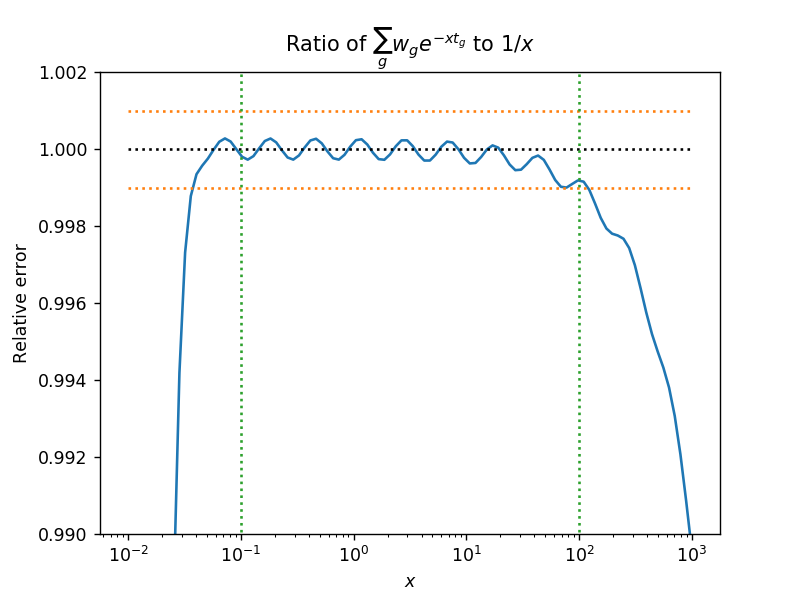

Text(0.5, 1.0, 'Ratio of $\\sum_g w_g e^{-x t_g}$ to $1/x$')

In [15]:
fig, ax = plt.subplots()

x_axis = np.logspace(-2, 3, 100)
y_axis = (grid_weights * np.exp(- x_axis[:, None] * grid_points)).sum(axis=-1) * x_axis
ax.plot(x_axis, y_axis)
ax.plot([1e-2, 1e3], [1.001, 1.001], color="C1", linestyle=":")
ax.plot([1e-2, 1e3], [1, 1], color="black", linestyle=":")
ax.plot([1e-2, 1e3], [0.999, 0.999], color="C1", linestyle=":")
ax.plot([1e-1, 1e-1], [0, 2], color="C2", linestyle=":")
ax.plot([1e2, 1e2], [0, 2], color="C2", linestyle=":")
ax.set_ylim(0.99,1.002)
ax.set_xscale("log")

ax.set_xlabel("$x$")
ax.set_ylabel("Relative error")
ax.set_title("Ratio of $\sum_g w_g e^{-x t_g}$ to $1/x$")

上图表示的是在不同 $x$ 取值下，我们所给出的格点积分 $w_g e^{-x t_g}$ 的精度；在 $x \in (0.1, 100)$ 的区间内我们仍然能保证 $0.1\%$ 的精度，但超过这些区域之后，结果就会迅速地变差。

我们知道，若分子呈现近简并的情形，那么 $x = D_{ij}^{ab}$ 会非常小；在这种情况下，LT 所提供的格点积分就很可能无法正确地描述分母 $D_{ij}^{ab}$ 的行为，使得本来在近简并就无法正常计算的 MP2 的情况雪上加霜。但若分子的 HOMO/LUMO 的能级差足够大并且大于 $0.1$ 个 Hartree，那么我们应当预期当前格点下的 LT 近似可以几乎精确地给出相关能。

### LT SOS MP2

现在我们就可以用上刚才的技术，对 LT SOS MP2 进行计算。这并不会提升任何计算效率；这里只是用来验证我们方才作的 LT 近似的有效性。

在 LT 近似下，SOS 能量可以表达为

$$
\begin{align}
E_\text{SOS-MP2, corr} &= 1.3 \frac{1}{D_{ij}^{ab}} (ia|jb)^2 \\
&= - 1.3 (ia|jb)^2 \int_0^{+\infty} e^{D_{ij}^{ab} t} \, \mathrm{d} t \\
&\simeq -1.3 w_g (ia|jb)^2e^{D_{ij}^{ab} t_g}
\end{align}
$$

这里的公式的正负号可能不太直观。这是因为在这篇文档的记号下，$D_{ij}^{ab} < 0$。我们通过如下代码，给出 LT SOS MP2 能量：

In [16]:
E_SOS_LT = - 1.3 * np.einsum("g, iajb, giajb ->", grid_weights, eri_iajb**2, np.exp(D_iajb * grid_points[:, None, None, None, None]))
print("LT-SOS-MP2 corr      in mH: ", E_SOS_LT * 1000)
print("Deviation to SOS-MP2 in mH: ", (E_SOS_LT - E_SOS_normal) * 1000)

LT-SOS-MP2 corr      in mH:  -344.2429384155852
Deviation to SOS-MP2 in mH:  0.00890840548417593


我们可以发现这是一个有效的近似。

## LT-DF SOS MP2

### DF 环境设置

在继续文档之前，我们需要对 DF 的环境作一些简单的设置。

In [17]:
auxmol = mol.copy()
auxmol.basis = "cc-pvtz-ri"
auxmol.build()

nao_df = auxmol.nao

In [18]:
int2c2e = auxmol.intor("int2c2e")
int2c2e.shape
int3c2e = df.incore.aux_e2(mol, auxmol)

int2c2e_half = scipy.linalg.cholesky(int2c2e, lower=True)
V_df_mp2 = scipy.linalg.solve_triangular(int2c2e_half, int3c2e.reshape(-1, nao_df).T, lower=True)\
               .reshape(nao_df, nao, nao).transpose((1, 2, 0))

尽管这里的 $V_{ia, P}$ `V_df_ia` 与前一篇文档中的 $V_{ia, P}^\mathrm{MP2}$ 是相同的，但需要注意到这里的轨道 $i$ 是价层的占据轨道，而不能是冻结的占据轨道。

In [19]:
V_df_ia = np.einsum("uvP, ui, va -> iaP", V_df_mp2, Cf, Cv)

### LT-DF SOS MP2 表达式

我们对上面提到的 LT SOS MP2 的近似表达式再作 DF 近似：

$$
\begin{align}
E_\text{SOS-MP2, corr} &\simeq -1.3 w_g (ia|jb)^2 e^{D_{ij}^{ab} t_g} \\
&\simeq -1.3 w_g V_{ia, P} V_{jb, P} V_{ia, Q} V_{jb, Q} e^{D_{ij}^{ab} t_g} \\
&= -1.3 w_g V_{ia, P} V_{jb, P} V_{ia, Q} V_{jb, Q} e^{D_i^a t_g} e^{D_j^b t_g}
\end{align}
$$

注意到最后一个等号利用到 $D_{ij}^{ab} = D_i^a + D_j^b$。

In [20]:
E_SOS_LTDF = - 1.3 * np.einsum("g, iaP, jbP, iaQ, jbQ, gia, gjb ->",
                               grid_weights, V_df_ia, V_df_ia, V_df_ia, V_df_ia,
                               np.exp(D_ia * grid_points[:, None, None]),
                               np.exp(D_ia * grid_points[:, None, None]))
print("LT-DF-SOS-MP2 corr   in mH: ", E_SOS_LTDF * 1000)
print("Deviation to SOS-MP2 in mH: ", (E_SOS_LTDF - E_SOS_normal) * 1000)

LT-DF-SOS-MP2 corr   in mH:  -344.1316103156453
Deviation to SOS-MP2 in mH:  0.12023650542408726


我们认为这基本重复出了原始的 SOS MP2 能量了。

### 简化公式表达

显然上面的公式表达太过于繁杂。在实际实现时，一般先将其中的三个张量缩并为 `X_gPQ`：

$$
X_{gPQ} = V_{ia, P} V_{ia, Q} e^{D_i^a t_g}
$$

In [21]:
X_gPQ = np.einsum("iaP, iaQ, gia -> gPQ", V_df_ia, V_df_ia, np.exp(D_ia * grid_points[:, None, None]))

那么 LT-DF 近似后的 SOS MP2 表达式可以简写为

$$
E_\text{SOS-MP2, corr} \simeq -1.3 w_g X_{gPQ}^2
$$

In [22]:
E_SOS_LTDF_simp = - 1.3 * np.einsum("g, gPQ ->", grid_weights, X_gPQ**2)
print("LT-DF-SOS-MP2 corr   in mH: ", E_SOS_LTDF_simp * 1000)
print("Deviation to SOS-MP2 in mH: ", (E_SOS_LTDF_simp - E_SOS_normal) * 1000)

LT-DF-SOS-MP2 corr   in mH:  -344.13161031563544
Deviation to SOS-MP2 in mH:  0.12023650543391273


### 计算效率比较

这里我们对 SOS MP2，LT SOS MP2 与 LT-DF SOS MP2 的计算效率进行比较，工具是 `np.einsum_path`。我们假定内存的空间是足够多的，并且不考虑为生成各种积分、或各种 DF 三中心积分所需要耗费的时间。

**普通 MP2**

效率耗时最大的部分在双电子积分转换过程。

In [23]:
print(np.einsum_path("ui, va, uvkl, kj, lb -> iajb",
    Cf, Cv, mol.intor("int2e"), Cf, Cv,
    optimize=["greedy", 1024 ** 3 * 2 / 8])[1])  # Given 2GB memory space

  Complete contraction:  ui,va,uvkl,kj,lb->iajb
         Naive scaling:  8
     Optimized scaling:  5
      Naive FLOP count:  3.801e+14
  Optimized FLOP count:  2.487e+09
   Theoretical speedup:  152841.286
  Largest intermediate:  9.365e+06 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   5               uvkl,ui->iklv                      va,kj,lb,iklv->iajb
   5               iklv,kj->ijlv                         va,lb,ijlv->iajb
   5               ijlv,va->ijal                            lb,ijal->iajb
   5               ijal,lb->iajb                               iajb->iajb


**DF SOS MP2**

效率耗时最大的部分在从 3c2e 积分生成双电子积分过程。

In [24]:
print(np.einsum_path("iaP, jbP -> iajb",
    V_df_ia, V_df_ia, 
    optimize=["greedy", 1024 ** 3 * 2 / 8])[1])  # Given 2GB memory space

  Complete contraction:  iaP,jbP->iajb
         Naive scaling:  5
     Optimized scaling:  5
      Naive FLOP count:  2.368e+08
  Optimized FLOP count:  2.368e+08
   Theoretical speedup:  1.000
  Largest intermediate:  4.199e+05 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   5               jbP,iaP->iajb                               iajb->iajb


**LT-DF SOS MP2**

效率耗时最大的部分在生成中间张量 $X_{gPQ}$ 的过程。

In [25]:
print(np.einsum_path("iaP, iaQ, gia -> gPQ",
    V_df_ia, V_df_ia, np.exp(D_ia * grid_points[:, None, None]),
    optimize=["greedy", 1024 ** 3 * 2 / 8])[1])  # Given 2GB memory space

  Complete contraction:  iaP,iaQ,gia->gPQ
         Naive scaling:  5
     Optimized scaling:  5
      Naive FLOP count:  2.783e+09
  Optimized FLOP count:  1.858e+09
   Theoretical speedup:  1.497
  Largest intermediate:  3.289e+06 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   4               gia,iaP->igaP                            iaQ,igaP->gPQ
   5               igaP,iaQ->gPQ                                 gPQ->gPQ


对于这个分子而言，放开优化张量缩并过程，结果反而会回到类似于 DF MP2 的缩并过程：

In [26]:
print(np.einsum_path("g, iaP, jbP, iaQ, jbQ, gia, gjb ->",
    grid_weights, V_df_ia, V_df_ia, V_df_ia, V_df_ia,
    np.exp(D_ia * grid_points[:, None, None]),
    np.exp(D_ia * grid_points[:, None, None]),
    optimize=["greedy", 1024 ** 3 * 2 / 8])[1])  # Given 2GB memory space

  Complete contraction:  g,iaP,jbP,iaQ,jbQ,gia,gjb->
         Naive scaling:  7
     Optimized scaling:  5
      Naive FLOP count:  4.207e+12
  Optimized FLOP count:  4.892e+08
   Theoretical speedup:  8600.264
  Largest intermediate:  4.199e+05 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   3                  gia,g->iga                iaP,jbP,iaQ,jbQ,gjb,iga->
   5               jbP,iaP->ijab                   iaQ,jbQ,gjb,iga,ijab->
   5               jbQ,iaQ->ijab                      gjb,iga,ijab,ijab->
   4             ijab,ijab->ijab                           gjb,iga,ijab->
   5               ijab,gjb->iga                                iga,iga->
   3                   iga,iga->                                       ->


**简单总结**

事实上，LT-DF SOS MP2 的优势并不体现在小分子的计算上，这从刚才的效率分析上就能看出来。但是，对于大分子 (占据电子数较多的情况，而非基组非常庞大的情况)，LT-DF MP2 就有不小的优势。这是因为耗时最大的部分的时间复杂度分别是

* LT-DF SOS MP2: $O(n_\mathrm{grid} n_\mathrm{nocc} n_\mathrm{nvir} n_\mathrm{aux}^2)$

* DF SOS MP2: $O(n_\mathrm{occ}^2 n_\mathrm{vir}^2 n_\mathrm{aux})$

我们可能会认为 $n_\mathrm{occ} < n_\mathrm{vir}$，而 $n_\mathrm{aux}$ 在基组较大时是 $n_\mathrm{vir}$ 的 3 倍左右。由于 $n_\mathrm{grid}$ 不随体系增大而变化，因此在 $n_\mathrm{grid} \ll n_\mathrm{occ}$ 的情况下，LT 的优势会凸显。

## 备注

这份文档颜文杰提供了 QChem 代码中关于 7 点 LT 格点的支持；尽管最终文档使用了自定义的等比级数格点，但 7 点 LT 格点帮助了文档的完成的过程。

[^Jung-Head-Gordon.JCP.2004.121]: Jung, Y.; Lochan, R. C.; Dutoi, A. D.; Head-Gordon, M. Scaled Opposite-Spin Second Order Møller–Plesset Correlation Energy: An Economical Electronic Structure Method. *J. Chem. Phys.* **2004**, *121* (20), 9793–9802. doi: [10.1063/1.1809602](https://doi.org/10.1063/1.1809602).